In [1]:
%%bash

pip install pyspark 
wget https://bdadata.s3.amazonaws.com/Complete_data.csv

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=cf181a48ff29d79abf4fc92d4ddafeeefdbaaf0dda7a77da151d3ab074f93ebe
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


--2022-04-22 01:07:20--  https://bdadata.s3.amazonaws.com/Complete_data.csv
Resolving bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)... 52.217.99.108
Connecting to bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)|52.217.99.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377494063 (360M) [text/csv]
Saving to: ‘Complete_data.csv’

     0K .......... .......... .......... .......... ..........  0% 2.33M 2m34s
    50K .......... .......... .......... .......... ..........  0% 1.18M 3m50s
   100K .......... .......... .......... .......... ..........  0% 1.26M 4m8s
   150K .......... .......... .......... .......... ..........  0% 65.9M 3m7s
   200K .......... .......... .......... .......... ..........  0% 2.41M 3m0s
   250K .......... .......... .......... .......... ..........  0% 73.5M 2m31s
   300K .......... .......... .......... .......... ..........  0%  153M 2m9s
   350K .......... .......... .......... .......... ..........  0%  175M 1m53s
   

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import FloatType

In [3]:
spark = SparkSession \
    .builder \
    .appName("Uber_lyft") \
    .getOrCreate()

In [4]:
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction","0.8")\
  .config("spark.executor.memory","12g")\
  .config("spark.driver.memory","12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize","0")\
  .getOrCreate()

sc=spark.sparkContext

In [5]:
cab_df = spark.read.option("inferSchema","true").option("header","true").csv("/content/Complete_data.csv")

In [6]:
cab_df.show(10)

+---+--------+--------+-------------+--------------------+----------------+-----+----------------+--------------------+------------+------------+--------------------+--------------------+-----+----------------+------+--------+------+-------------+--------+-----+--------------------+--------------------+---+----+
|_c0|distance|cab_type|   time_stamp|         destination|          source|price|surge_multiplier|                  id|  product_id|        name|           date_time|          merge_date| temp|        location|clouds|pressure|  rain| time_stamp_w|humidity| wind|         date_time_w|        merge_date_w|day|hour|
+---+--------+--------+-------------+--------------------+----------------+-----+----------------+--------------------+------------+------------+--------------------+--------------------+-----+----------------+------+--------+------+-------------+--------+-----+--------------------+--------------------+---+----+
|  0|    0.44|    Lyft|1544952607890|       North Station|

In [7]:
cab_df.toPandas().shape

(1164996, 25)

In [8]:
my_df = cab_df.select("distance","cab_type","destination","source")
my_df = my_df.withColumn("distance",col("distance").cast("Float"))
my_df.show(10)

+--------+--------+--------------------+----------------+
|distance|cab_type|         destination|          source|
+--------+--------+--------------------+----------------+
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
+--------+--------+--------------------+----------------+
only showing top 10 rows



In [9]:
def display_metrics(x):
  print("Longest trip: ",(my_df.select(max(x)).collect()))
  print("Shortest trip: ",my_df.select(min(x)).collect())
  print("Average length of trips: ",my_df.select(avg(x)).collect())
  print("Longest trip using Uber: ",my_df.filter(my_df.cab_type == "Uber").select(max(x)).collect())
  print("Longest trip using Lyft: ",my_df.filter(my_df.cab_type == "Lyft").select(max(x)).collect())
  print("Average trip using Uber: ",my_df.filter(my_df.cab_type == "Uber").select(avg(x)).collect())
  print("Average trip using Lyft: ",my_df.filter(my_df.cab_type == "Lyft").select(avg(x)).collect())

In [10]:
display_metrics("distance")

Longest trip:  [Row(max(distance)=7.860000133514404)]
Shortest trip:  [Row(min(distance)=0.019999999552965164)]
Average length of trips:  [Row(avg(distance)=2.1895498610588024)]
Longest trip using Uber:  [Row(max(distance)=7.860000133514404)]
Longest trip using Lyft:  [Row(max(distance)=6.329999923706055)]
Average trip using Uber:  [Row(avg(distance)=2.192162321008794)]
Average trip using Lyft:  [Row(avg(distance)=2.1867383185852387)]


In [11]:
def ret_destination(x):
  return (x[2],1)
def destination_count(val1,val2):
  return (val1+val2)

destination_count = my_df.rdd.map(ret_destination).reduceByKey(destination_count).toDF()

In [12]:
destination_count.columns

['_1', '_2']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popular Destinations of Boston')

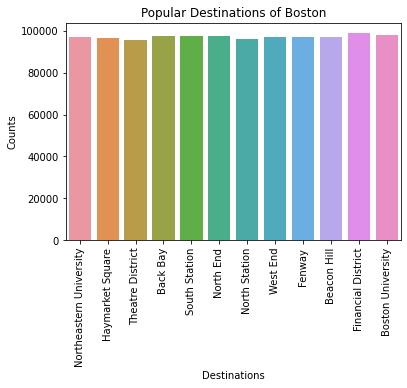

In [13]:
sns.barplot(destination_count.toPandas()["_1"],destination_count.toPandas()["_2"])
plt.xticks(rotation=90)
plt.xlabel("Destinations")
plt.ylabel("Counts")
plt.title("Popular Destinations of Boston")

In [14]:
def ret_source(x):
  return (x[3],1)
def source_count(val1,val2):
  return (val1+val2)
source_count = my_df.rdd.map(ret_source).reduceByKey(source_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popular Sources of Boston')

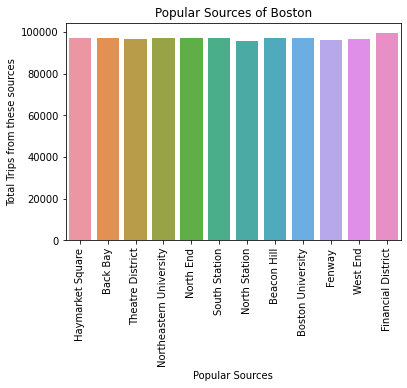

In [15]:
sns.barplot(source_count.toPandas()["_1"],source_count.toPandas()["_2"])
plt.xticks(rotation=90)
plt.xlabel("Popular Sources")
plt.ylabel("Total Trips from these sources")
plt.title("Popular Sources of Boston")

In [16]:
def cab_company(x):
  return (x[1],1)
def company_count(val1,val2):
  return (val1+val2)
company_counts_df = my_df.rdd.map(cab_company).reduceByKey(company_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popularity of the Companies')

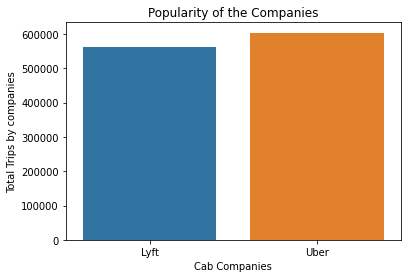

In [17]:
sns.barplot(company_counts_df.toPandas()["_1"],company_counts_df.toPandas()["_2"])
plt.xlabel("Cab Companies")
plt.ylabel("Total Trips by companies")
plt.title("Popularity of the Companies")

In [18]:
def trip_lengths(x):
  return (x[0],1)
def length_count(val1,val2):
  return (val1+val2)
length_trips = my_df.rdd.map(trip_lengths).reduceByKey(length_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count of trips')

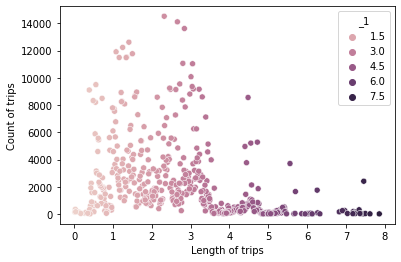

In [19]:
sns.scatterplot(length_trips.toPandas()["_1"],length_trips.toPandas()["_2"],hue=length_trips.toPandas()["_1"])
plt.xlabel("Length of trips")
plt.ylabel("Count of trips")

{'boxes': [<matplotlib.lines.Line2D at 0x7efccda78110>],
 'caps': [<matplotlib.lines.Line2D at 0x7efccda8c150>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efccda9e6d0>],
 'means': [<matplotlib.lines.Line2D at 0x7efccda9e190>],
 'medians': [<matplotlib.lines.Line2D at 0x7efccda8cc10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efcdc6e9250>,
  <matplotlib.lines.Line2D at 0x7efccda78bd0>]}

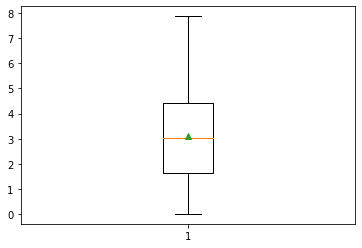

In [20]:
plt.boxplot(length_trips.toPandas()["_1"],showmeans=True,showcaps=True)